# Author enrichment
Development notebook for code looking at conference author enrichment.

In [75]:
import jsonlines
import networkx as nx
import pandas as pd
import numpy as np
from infomap import Infomap
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data

In [2]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_with_authors_FILTERED_24Jan2023.jsonl') as reader:
    data = [obj for obj in reader]

In [3]:
graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

In [4]:
attendees_2016 = pd.read_excel('../data/conference_data/2016_DesWork_Delegate_List.xlsx')
attendees_2016 = attendees_2016.rename(columns={'First name': 'First_name'})
attendees_2016.head()

,Surname,First_name,Affiliation,Country
0,Barak,Simon,Ben-Gurion University of the Negev,Israel
1,Bar-Eyal,Leeat,The Hebrew University of Jerusalem,Israel
2,Bentley,Joanne,University of Cape Town,South Africa
3,Bharuth,Vishal,University of KwaZulu Natal,South Africa
4,Borner,Andreas,Leibniz Institute of Plant Genetics & Crop Pla...,Germany


In [5]:
attendees_2024 = pd.read_excel('../data/conference_data/20240102_RegChecklist.xlsx')
attendees_2024['First_name'] = [' '.join([name_elt for name_elt in full_name if name_elt not in last_name]) for full_name, last_name in zip(attendees_2024['Name'].str.split(), attendees_2024['Last Name'].str.split())]
attendees_2024 = attendees_2024.rename(columns={'Last Name': 'Surname', 'Institution': 'Affiliation'})
attendees_2024 = attendees_2024.drop(columns=['Name', 'Title'])
attendees_2024.head()

,Surname,Affiliation,Country,First_name
0,Artur,Wageningen University & Research,Netherlands,Mariana A. S.
1,Baluku,University of Cape Town,Uganda,Erikan
2,Boothby,University of Wyoming,United States,Thomas
3,Bradford,"University of California, Davis",United States,Kent
4,Buitink,INRAE IRHS,France,Julia


In [6]:
alt_names_2024 = pd.read_excel('../data/conference_data/alternative_publishing_names_2024.xlsx')
alt_names_2024.head()

,Registration_surname,Registration_first_name,Alternative_name_1,Alternative_name_2,Alternative_name_3,Maiden_name
0,Artur,Mariana A. S.,Mariana Silva Artur,Mariana Artur,Mariana Aline Silva Artur,NaN
1,Baluku,Erikan,NaN,NaN,NaN,NaN
2,Boothby,Thomas,Thomas C. Boothby,Thomas Christopher Clark Boothby,NaN,NaN
3,Bradford,Kent,Kent J. Bradford,NaN,NaN,NaN
4,Buitink,Julia,NaN,NaN,NaN,NaN


## Clustering algorithms

Choosing the right clustering algorithm for an empirical task is difficult because none of the stand-alone quality metrics that can be calculated on empirical (real-world) networks reliably reflect information retreival capabilities, as discussed in [Emmons et al 2016](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0159161). The authors found that conductance was the metric that correlated best with information retrieval, and that the Infomap clustering algorithm had the highest conductance on a real-world dataset of co-authorships, which is relatively similar to the kind of network we're working with, so we'll start with the `infomap` package for Python.

Some salient initial details about `infomap` from [the docs](https://www.mapequation.org/infomap/):
* Infomap handles both unweighted and weighted, undirected and directed links.
* Infomap clusters tightly interconnected nodes into modules (two-level clustering) or the optimal number of nested modules (multi-level clustering)
    * I'll perform two-level clustering here to begin with

In [62]:
# Build network in Infomap
im = Infomap(clu=True, seed=1234)
mapping = im.add_networkx_graph(graph)

In [63]:
# Run the clustering algorithm
im.run()

  Infomap v2.7.1 starts at 2024-01-25 16:53:30
  -> Input network: 
  -> No file output!
  -> Configuration: clu
                    seed = 1234
  OpenMP 201511 detected with 1 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 

In [64]:
# Get output
cluster_output = im.get_dataframe(columns=["node_id", "module_id", "name"])
cluster_output.head()


  -> Using unrecorded teleportation to links. (Normalizing ranks after 0 power iterations with error -3.03607572e-05) 
  -> PageRank calculation done in 58 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 5564 nodes and 41995 links...
  -> One-level codelength: 9.77797916

Trial 1/1 starting at 2024-01-25 16:53:30
Two-level compression: 18% 2.3% 0.0174579947% 0.0505075094% 0.00388751037% 
Partitioned to codelength 1.9057605 + 5.9298387 = 7.8355992 in 574 (167 non-trivial) modules.
Super-level compression: 0.548838812% to codelength 7.79259439 in 434 top modules.

Recursive sub-structure compression: 10.5084948% 0.104446176% 0.00254699959% 0% 

,node_id,module_id,name
0,114,1,WOS:000166537400004
1,460,1,WOS:000085277800001
2,107,1,WOS:000072812400006
3,515,1,WOS:000184821900010
4,108,1,WOS:000234240100013


In [65]:
print(f'There are {len(cluster_output.module_id.unique())} unique clusters in the network.')

There are 434 unique clusters in the network.


In [66]:
# Write out to pajek format to use online visualization tool
im.write_pajek('../data/citation_network/citenet.pajek')

#### NOTE
I am not totally clear on the interpretation of the output of this clustering algorithm, but I'm going to move ahead with the assumption that there are top-level clusters reflected by module number. Need to confirm that this is a valid interpretation.

## Author name normalization
Before we can go about calculating author enrichment, we need to figure out how to match the names provided by DesWorks to the names in the WoS dataset. There are a few ways that names can be formatted in WoS, so we'll write a function to check all conference attendees' names in all three formats.

In [20]:
char_11_names = [paper for paper in data if 1964 <= int(paper['year']) <= 1975]
pre_2006_names = [paper for paper in data if (int(paper['year']) < 2006) and (paper not in char_11_names)]
modern_names = [paper for paper in data if (paper not in char_11_names) and (paper not in pre_2006_names)]

In [21]:
print(f'{len(char_11_names)} papers are from between 1964 - 1975, {len(pre_2006_names)} are from the period where only '
     f'first initial was recorded, and {len(modern_names)} are from the era where full name is recorded. Remember that '
     'it is possible that some older entries have been updated since 2006 and may contain full names.')

10 papers are from between 1964 - 1975, 1799 are from the period where only first initial was recorded, and 4154 are from the era where full name is recorded. Remember that it is possible that some older entries have been updated since 2006 and may contain full names.


In [42]:
def process_alt_names(alt_names):
    """
    Turn an alternative name dataframe into a dict indexed by WOS standard names self-reported by attendees.
    
    parameters:
        alt_names, df: columns are columns are Registration_surname, Registration_first_name,
            Alternative_name_1..., Maiden_name
        
    returns:
        alt_names_dict, dict: keys are "surname, initials", values are lists of tuple with (last name, first name)
            alternative names
    """
    alt_names_dict = {}
    for row in alt_names.iterrows():
        row = row[1]
        key = f'{row.Registration_surname.lower()}, {"".join([n[0] for n in row.Registration_first_name.split()]).lower()}'
        names = []
        # Get alternative names with same surname
        for name in row.tolist()[2:-1]:
            if not isinstance(name, str):
                continue
            split_name = name.split(' ')
            # Remove surname to get first name
            ## TODO deal with the specific edge cases where this fails for our attendees in manual pre-processing
            surname = row.Registration_surname.split(' ')
            first_name = [i for i in split_name if i not in surname]
            full_name = (' '.join(surname).lower(), ' '.join(first_name).lower())
            names.append(full_name)
        if isinstance(row.Maiden_name, str): 
            name = (row.Maiden_name.lower(), row.Registration_first_name.lower())
            names.append(name)
        alt_names_dict[key] = names
    
    return alt_names_dict

In [55]:
def find_author_papers(attendees, dataset, additional_names):
    """
    Find papers that were authored by conference attendees.
    
    parameters:
        attendees, df: columns are Surname, First_name, Affiliation, Country
        dataset, list of dict: WoS papers with author and affiliation data
        additional_names, dict: formatted as per process_alt_names output
        
    returns:
        conference_authors, dict: keys are DesWorks recorded author names in WOS standard, values are WOS UIDs
    """
    ## TODO edge cases
    # 1. Names with internal punctuation (e.g. O'Neill, Farooq-E-Azam)
    # 2. Chinese names
    # 3. Papers between 64-75 for authors with last names more than 8 characters
    
    # Process attendees to strip trailing whitespace and to lowercase
    for col in attendees.columns:
        attendees[col] = attendees[col].str.strip().str.lower()
    
    # Maiden names
    maiden_names = {name[0]: wos_name for wos_name, name_list in additional_names.items() for name in name_list}
    
    # Check for conference authors
    conference_authors = {f'{surname.lower()}, {"".join([n[0] for n in first_name.split()]).lower()}': [] for surname, first_name in zip(attendees['Surname'], attendees['First_name'])}
    for paper in dataset:
        # Check only surname first
        surnames = []
        for a in paper['authors']:
            try:
                surnames.append(a['last_name'].lower())
            except KeyError:
                # Dot 11-character names don't have a last name and we want to include them
                # Other authors with no last name are mostly organizations or repeats
                try:
                    if len(a['wos_standard'].split('.')) == 2:
                        ## TODO #3
                        surnames.append(a['wos_standard'].split('.')[0].lower())
                except KeyError:
                    continue
        for name in surnames:
            # If surname is present, confirm with wos standard (including first name) name
            if (name in attendees.Surname.tolist()) or (name in maiden_names.keys()):
                # Change maiden name to registered name if relevant
                if name in maiden_names.keys():
                    name = maiden_names[name].split(', ')[0]
                # Get the rows with this surname, possible multiple have same surname
                possible_authors = attendees[attendees['Surname'] == name][['Surname', 'First_name']]
                # Process first names to initials
                possible_first_names = possible_authors.First_name.tolist()
                possible_initials = ["".join([n[0] for n in fn.split()]) for fn in possible_first_names]
                # Get first name as initial name format
                pre_2006s_and_WOS_standard = [f'{name}, {initials}' for initials in possible_initials]
                # Get alternative names for these possible authors
                possible_first_names += [name[1] for prename in pre_2006s_and_WOS_standard for name in additional_names[prename]]
                possible_initials += ["".join([n[0] for n in name[1].split()]) for prename in pre_2006s_and_WOS_standard for name in additional_names[prename]]
                pre_2006s_and_WOS_standard += [f'{name}, {initials}' for initials in possible_initials]
                # Get possible oldest name format
                char_11s_space = [f'{name[:8]}, {initials}' for initials in possible_initials]
                char_11s_period = [f'{name[:8]}.{initials}' for initials in possible_initials] 
                # Get full name
                full_names = [f'{name}, {first_name}' for first_name in possible_first_names]
                # Combine for all possibilities
                to_check = char_11s_space + char_11s_period + pre_2006s_and_WOS_standard + full_names
                # Now check all names against paper authors
                for author in paper['authors']:
                    full_authors_found = []
                    if (author['full_name'].lower() in to_check) or (author['wos_standard'].lower() in to_check):
                        if len(possible_authors) == 1:
                            try:
                                conference_authors[author['wos_standard'].lower()].append(paper['UID'])
                            except KeyError:
                                ## TODO I think this works for my particular observed cases, but does not generalize, need to generalize
                                key = pre_2006s_and_WOS_standard[0] if pre_2006s_and_WOS_standard[0].split(', ')[0][0] == author['wos_standard'].lower().split(', ')[1][0] else pre_2006s_and_WOS_standard[1]
                                conference_authors[key].append(paper['UID'])
                        else:
                            full_authors_found.append(author['wos_standard'].lower())
                if len(full_authors_found) != 0:
                    for author_name in full_authors_found:
                        conference_authors[author_name].append(paper['UID'])

    return conference_authors

In [56]:
## TODO alt names manual check
# conf_authors_2016 = find_author_papers(attendees_2016, data)

In [57]:
alt_names_2024_processed = process_alt_names(alt_names_2024)
conf_authors_2024 = find_author_papers(attendees_2024, data, alt_names_2024_processed)

In [58]:
conf_authors_2024

{'artur, mas': ['WOS:000467953500010',
  'WOS:000672172900001',
  'WOS:000402875600010',
  'WOS:000496157300005',
  'WOS:000497661700002'],
 'baluku, e': [],
 'boothby, t': ['WOS:000588088300001',
  'WOS:000396431900006',
  'WOS:000863482300001',
  'WOS:000590552400004',
  'WOS:000413666000007',
  'WOS:000630606400001',
  'WOS:000499248400001',
  'WOS:000426660800181',
  'WOS:000396046900695',
  'WOS:000209928400266',
  'WOS:000465027500010'],
 'bradford, k': ['WOS:000089733500010',
  'WOS:000089733500005',
  'WOS:000231769200029',
  'WOS:A1994MW91800017',
  'WOS:000231769200005',
  'WOS:000231769200038',
  'WOS:A1995TQ47100002',
  'WOS:000185076100050',
  'WOS:A1989CJ10600010',
  'WOS:000089733500006',
  'WOS:000089733500008',
  'WOS:000231769200039',
  'WOS:000231769200037',
  'WOS:000089733500016',
  'WOS:000089733500011',
  'WOS:000176210800011',
  'WOS:A1992JA21800022',
  'WOS:000436185600009',
  'WOS:000231769200030',
  'WOS:000089733500015',
  'WOS:000089733500020',
  'WOS:00008

#### TODO
Manually check the results above to make sure it's working properly

## Author enrichment
Now we can calculate what percentage of authors in the various network clusters belong to conference attendees.

In [61]:
attendee_2024_paper_UIDs = [uid for author, papers in conf_authors_2024.items() for uid in papers]
print(f'There are {len(attendee_2024_paper_UIDs)} papers published by attendees of the 2024 conference.')

There are 383 papers published by attendees of the 2024 conference.


The simplest thing we can do first is to calculate the percentage of papers in each cluster that have conference authors, and make a histogram of the various clusters.

In [81]:
print(f'There are {len(cluster_output.module_id.unique())} clusters.')

There are 434 clusters.


In [72]:
cluster_props = {}
for cluster_id in cluster_output.module_id.unique():
    papers = cluster_output[cluster_output['module_id'] == cluster_id].name.tolist()
    total_num = len(papers)
    conf_num = 0
    for paper in papers:
        if paper in attendee_2024_paper_UIDs:
            conf_num += 1
    cluster_prop = conf_num/total_num
    cluster_props[cluster_id] = cluster_prop

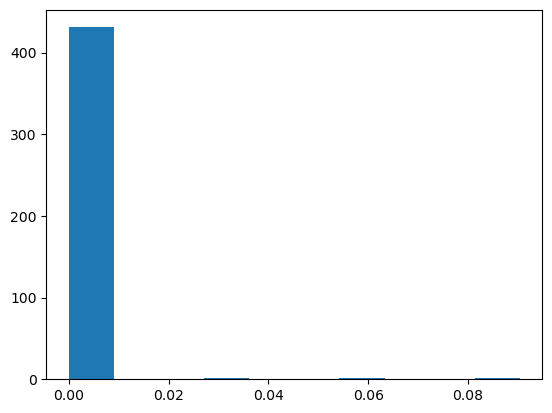

In [78]:
_ = plt.hist(cluster_props.values(), bins=10)

Most clusters don't have any conference authors, while three clusters do; this is what we would expect, since there are only 383 of ~5500 papers that have conference authors! What happens if we exclude clusters that have fewer than a given number of papers? Since we want to do topic modeling, we want to have some baseline number of abstracts in each cluster.

In [79]:
cluster_props_thresh5 = {}
for cluster_id in cluster_output.module_id.unique():
    papers = cluster_output[cluster_output['module_id'] == cluster_id].name.tolist()
    total_num = len(papers)
    if total_num <= 5:
        continue
    conf_num = 0
    for paper in papers:
        if paper in attendee_2024_paper_UIDs:
            conf_num += 1
    cluster_prop = conf_num/total_num
    cluster_props_thresh5[cluster_id] = cluster_prop

In [83]:
print(f'There are {len(cluster_props_thresh5.keys())} clusters with more than 5 documents.')

There are 8 clusters with more than 5 documents.


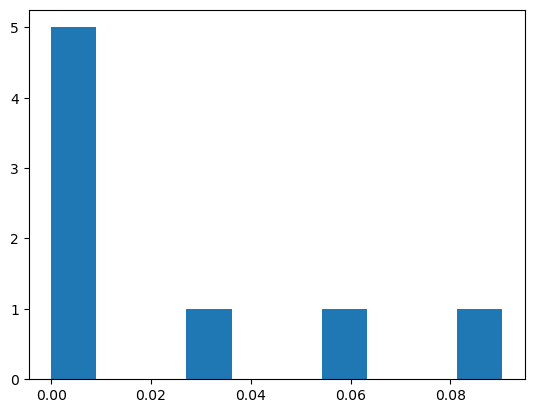

In [80]:
_ = plt.hist(cluster_props_thresh5.values(), bins=10)

It does look like we might want to investigate other clustering methods, as msot clusters here are less than 5 documents, which isn't super useful to us.